# Serverless Inference API

_Authored by: [Andrew Reed](https://huggingface.co/andrewrreed)_

Hugging Face provides a [Serverless Inference API](https://huggingface.co/docs/api-inference/index) as a way for users to quickly test and evaluate over 500,000 publicly accessible (or your own privately permissioned) machine learning models with simple API calls ***for free***!

In this notebook recipe, we'll demonstrate several different ways you can query the Serverless Inference API while exploring various tasks including: generating text with open LLM's, creating images with stable diffusion, transcribing audio files with Whisper, and performing visual question answering against PDFs. The goal is to help you get started by covering the basics!


> **Note:** Because we offer the Serverless Inference API for free, there are rate limits for regular Hugging Face users (~ few hundred requests per hour). For access to higher rate limits, you can [upgrade to a PRO account](https://huggingface.co/subscribe/pro) for just $9 per month. However, for high-volume, production inference workloads, check out our [Dedicated Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) solution.


## Let's get started

To begin using the Serverless Inference API, you'll need an account on the Hugging Face Hub: [Register](https://huggingface.co/join) or [Login](https://huggingface.co/login). Next, you'll need to create a [User Access Token](https://huggingface.co/docs/hub/security-tokens) with `read` or `write` permissions.

With those steps out of the way, we can install our required packages and authenticate to the Hub with our User Access Token.

In [ ]:
%pip install -U huggingface_hub

In [1]:
import os
from huggingface_hub import interpreter_login, whoami, get_token

# running this will prompt you to enter your Hugging Face credentials
interpreter_login()

/Users/andrewreed/Documents/cookbook/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> **Note:** We've used the `interpreter_login()` above to programatically login to the Hub. As an alternative, we could also use other methods like `notebook_login()` from the [Hub Python Library](https://huggingface.co/docs/huggingface_hub/en/package_reference/login) or `login` command from the [Hugging Face CLI tool](https://huggingface.co/docs/huggingface_hub/en/guides/cli#huggingface-cli-login).

Now, lets verify we're properly logged in using `whoami()` to print out the active username and the organizations your profile belongs to.

In [ ]:
whoami()

And then finally, we'll set our token as an environment variable for ease of access from our bash shell

In [3]:
os.environ["HF_TOKEN"] = get_token()

## Querying the Serverless Inference API

The Inference API exposes models on the Hub with a simple API - `https://api-inference.huggingface.co/models/<MODEL_ID>` - where `<MODEL_ID>` corresponds to the name of the model repo on the Hub.

For example, [codellama/CodeLlama-7b-hf](https://huggingface.co/codellama/CodeLlama-7b-hf) --> https://api-inference.huggingface.co/models/codellama/CodeLlama-7b-hf

### With an HTTP request

We can easily call this API with a simple `POST` request via the `curl` utility:

In [24]:
!curl https://api-inference.huggingface.co/models/codellama/CodeLlama-7b-hf \
	-X POST \
	-d '{"inputs": "A post request is used to ", "parameters": {"temperature": 0.8, "max_new_tokens": 200}}' \
	-H 'Content-Type: application/json' \
    -H "Authorization: Bearer $HF_TOKEN"

[{"generated_text":"A post request is used to \nlater add the current user to the group that has been created in the previous step.\n\n```js\n// Define the request for adding the user to the created group\n$postRequest = $api->getGroupApi()->addUser(123, \"testUser\");\n$user = $postRequest->getAddedUser()->get(\"testUser\");\n\n// Execute the request\n$group = $postRequest->execute();\n\n```\n\n##"}]

Nice! The API responded with a continuation of our input prompt. But you might be wondering how did the API know what to do with the payload? And how do I know which parameters can be passed for a given model?

Behind the scenes, the inference API will dynamically load the model onto shared compute infrastructure to serve requested predictions. When the model is loaded, the Serverless Inference API will use the specified `pipeline_tag` from the Model Card (see [here](https://huggingface.co/codellama/CodeLlama-7b-hf/blob/main/README.md?code=true#L4)) to determine the appropriate inference task. You can reference the corresponding [task](https://huggingface.co/tasks) or [pipeline](https://huggingface.co/docs/transformers/en/main_classes/pipelines) documentation to find the allowed arguments.


> **Note:** If the requested model is not already loaded into memory at the time of request (which is determined by recent requests for that model), the Serverless Inference API will initially return a 503 response, before it can successfully respond with the prediction. Try again after a few moments to allow the model time to spin up.

### With the `huggingface_hub` Python library

To send your requests in Python, you can take advantage of the `InferenceClient` - a convenient utility available in the `huggingface_hub` Python library that allows you to easily make calls to the Serverless Inference API.

In [3]:
from huggingface_hub import InferenceClient

client = InferenceClient()
response = client.text_generation(
    prompt="A post request is used to ",
    model="codellama/CodeLlama-7b-hf",
    temperature=0.8,
    max_new_tokens=200,
)
print(response)

send information from HTML form to the server,  usually by Ajax.

Post request has no intrinsic meaning, like get request does. It is the developer who assigns a meaning for it, for example, a post request might represent a sign up form, or a purchase confirmation.

### 2. What are the differences between PUT and POST?

In HTTP, the PUT method typically is used to update a resource while the POST method typically is used to create a new resource. But, as I have mentioned before, PUT or POST does not necessarily mean to update or create a resource. For example, in RESTful API, the PUT could be used to modify a resource via PUT, and the POST could be used to create a resource via POST.

Also, please note that PUT is not limited to update a resource. A PUT request could also be used to create a resource if you want to emulate the


Notice that with the `InferenceClient`, we specify just the model ID, and also pass arguments directly in the `text_generation()` method. We can easily inspect the function signature to see more details about how to use the task and its allowable parameters.

> In addition to Python, you can also use JavaScript to integrate inference calls inside your JS or node apps. Take a look at [huggingface.js](https://huggingface.co/docs/huggingface.js/index) to get started!

In [6]:
# uncomment the following line to see the function signature
# help(client.text_generation)

## Applications

Now that we know how the Serverless Inference API works, let's take it for a spin.

### 1. Generating Text with Open LLMs

Text generation is a very common use case. However, interacting with open LLMs has some subleties that are important to understand to avoid silent performance degradation. When it comes to text generation, the underlying language model may come in a couple different flavors:
- **Base models:** refer to plain, pre-trained language models like [codellama/CodeLlama-7b-hf](https://huggingface.co/codellama/CodeLlama-7b-hf) from above or [meta-llama/Meta-Llama-3-8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B). These models are good at continuing generation from a provided prompt (like we saw in the example above for code completion). However, they have not been fine-tuned for conversational use like answering questions.
- **Instruction-tuned models:** are trained in a multi-task manner to follow a broad range of instructions like "Write me a recipe for chocolate cake". Models like [meta-llama/Meta-Llama-3-8B-Instruct](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) or [mistralai/Mistral-7B-Instruct-v0.3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) are trained in this manner. In general, instruction-trained models will produce better responses to instructions than base models. They are often also fine-tuned for multi-turn chat dialogs, making them great for conversational use cases.


These subtle differences are important to understand because they affect the way in which we should query a particular model. Models prepared to follow chat conversations are trained with very specific chat templates that depend on the model used. You need to be careful about the format the model expects and replicate it in your queries.

For example, [meta-llama/Meta-Llama-3-8B-Instruct](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) uses the following prompt structure to delineate between system, user, and assistant dialog turns:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{{ system_prompt }}<|eot_id|><|start_header_id|>user<|end_header_id|>

{{ user_msg_1 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{{ model_answer_1 }}<|eot_id|>
```

The special tokens, and usage schema vary model to model. To make sure we're using the correct format, we can make use of a model's [chat template](https://huggingface.co/docs/transformers/main/en/chat_templating) via it's tokenizer.

In [4]:
from transformers import AutoTokenizer


system_input = "You are an expert prompt engineer with artistic flair."
user_input = "Write a prompt to generate an intriguing image containing a llama and a pirate hat. Keep it concise and only return the prompt."
messages = [
    {"role": "system", "content": system_input},
    {"role": "user", "content": user_input},
]

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
print(f"\nPROMPT:\n-----\n\n{prompt}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



PROMPT:
-----

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an expert prompt engineer with artistic flair.<|eot_id|><|start_header_id|>user<|end_header_id|>

Write a prompt to generate an intriguing image containing a llama and a pirate hat. Keep it concise and only return the prompt.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




Notice how the `apply_chat_template()` method has taken our familiar list of messages and converted them into the properly formated string that our model expects? We can use this formatted string to pass to the Serverless Inference API endpoint:

In [7]:
response = client.text_generation(prompt, model=model_id, max_new_tokens=250)
print(response)

"Create an enchanting scene where a curious llama, surrounded by a mystical fog, dons a worn pirate hat, as if it's discovered a hidden treasure, with the hat's brim adorned with sparkling gemstones and the llama's fur glowing with an ethereal aura."


Querying an LLM without adhering to the model's prompt template _will not_ produce any outright errors, but will result in poor quality outputs which is why we emphasize this concept here. To simplify this process and ensure the proper chat template is being used, the `InferenceClient` also offers a `chat_completion` method that abstracts away the `chat_template` details allowing you to simply pass a list of messages:

In [9]:
for token in client.chat_completion(
    messages, model=model_id, max_tokens=250, stream=True
):
    print(token.choices[0].delta.content)

"
Create
 an
 en
igmatic
 illustration
 of
 a
 llama
 sporting
 a
 worn
,
 elegant
 pirate
 hat
,
 set
 against
 a
 celestial
 background
 with
 sprink
les
 of
 st
ard
ust
 and
 a
 faint
 cres
cent
 moon
,
 conveying
 a
 sense
 of
 whims
y
 and
 myst
ique
."



In the example above, we've also set `stream=True` to enable streaming text from the endpoint. To learn about more functionality like this and about best practices when querying LLMs, we recommend diving into these supporting resources:
1. [How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)
2. [Text generation strategies](https://huggingface.co/docs/transformers/generation_strategies)
3. [Inference for PROs](https://huggingface.co/blog/inference-pro) - particularly the section on [controlling text generation](https://huggingface.co/blog/inference-pro#controlling-text-generation)
4. [Inference Client Docs](https://huggingface.co/docs/huggingface_hub/en/package_reference/inference_client#inference)


### 2. Creating Images with Stable Diffusion

The Serverless Inference API can be used for [all sorts of tasks](https://huggingface.co/tasks). Let's use the `InferenceClient` along with our newly generated prompt to create an image with [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0).

PROMPT:  "Create an enchanting scene where a curious llama, surrounded by a mystical fog, dons a worn pirate hat, as if it's discovered a hidden treasure, with the hat's brim adorned with sparkling gemstones and the llama's fur glowing with an ethereal aura."


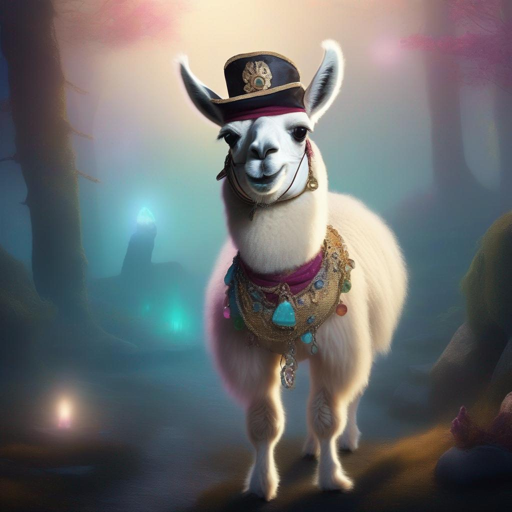

In [10]:
image = client.text_to_image(
    prompt=response,
    model="stabilityai/stable-diffusion-xl-base-1.0",
    guidance_scale=8,
)

print("PROMPT: ", response)
image.resize((image.width // 2, image.height // 2))

#### Caching

If you run the same generation multiple times, you’ll see that the result returned by the API is the same. This is because recent results are locally cached. To force a different response each time, we can use an HTTP header to tell the server to run a new generation each time: `x-use-cache: 0`.



PROMPT:  "Create an enchanting scene where a curious llama, surrounded by a mystical fog, dons a worn pirate hat, as if it's discovered a hidden treasure, with the hat's brim adorned with sparkling gemstones and the llama's fur glowing with an ethereal aura."


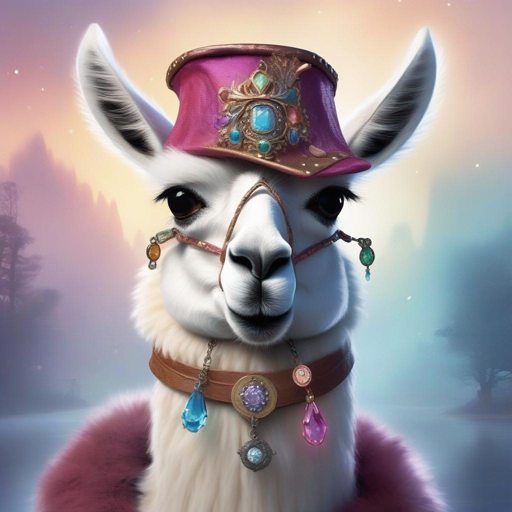

In [11]:
# turn caching off
client.headers["x-use-cache"] = "0"

# generate a new image with the same prompt
image = client.text_to_image(
    prompt=response,
    model="stabilityai/stable-diffusion-xl-base-1.0",
    guidance_scale=8,
)

print("PROMPT: ", response)
image.resize((image.width // 2, image.height // 2))

### 3. Reasoning Over Images with Idefics2

Vision language models (VLMs) are models that can simultaneously reason over images and texts to tackle many tasks, from visual question answering to image captioning. Let's use the Serverless Inference API to query [Idefics2](https://huggingface.co/blog/idefics2), a powerful 8B parameter VLM.

We first need to convert our PIL image to a base64 encoded string so that we can send it to the model over the network.

In [13]:
import base64
from io import BytesIO
from transformers import AutoProcessor


def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


image_b64 = pil_image_to_base64(image)

Then, we can format our text + image prompt correctly using a chat template. See the [Idefics2 model card](https://huggingface.co/HuggingFaceM4/idefics2-8b) for specific details on prompt formatting. 

In [15]:
vlm_model_id = "HuggingFaceM4/idefics2-8b-chatty"
processor = AutoProcessor.from_pretrained(vlm_model_id)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Write a short limerick about this image."},
        ],
    },
]

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)


image_input = f"data:image/jpeg;base64,{image_b64}"
image_input = f"![]({image_input})"
prompt = prompt.replace("<image>", image_input)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


And then finally call the Serverless API to get a prediction. In our case, a fun limerick about our generated image!

In [34]:
limerick = client.text_generation(
    prompt,
    model=vlm_model_id,
    max_new_tokens=200,
)
print(limerick)

 There once was a llama so grand,
With a hat and a necklace in hand.
He wore a pink hat with a gold band,
And jewels that sparkled like sand.
In the sky, he stood tall and proud,
A sight that was truly profound.


### 4. Generating Speech from Text

To close out our applications, let's use a transformers-based, text-to-audio model called [Bark](https://huggingface.co/suno/bark) to read us our new poem.

In [42]:
tts_model_id = "suno/bark"
speech_out = client.text_to_speech(text=limerick, model=tts_model_id)

In [43]:
from IPython.display import Audio

print(limerick)
Audio(speech_out, rate=24000)

 There once was a llama so grand,
With a hat and a necklace in hand.
He wore a pink hat with a gold band,
And jewels that sparkled like sand.
In the sky, he stood tall and proud,
A sight that was truly profound.
